In [1]:
cd ..

/home/rd804/m-anode


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *
import os
from src.utils import *
from src.nflow_utils import *
from src.generate_data_lhc import *
from src.utils import *
from src.flows import *

from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ShuffleSplit
import argparse
import pickle
import wandb
import sys


In [6]:


parser = argparse.ArgumentParser()
parser.add_argument('--n_sig',type=int , default=1000, help='signal train')
parser.add_argument('--mode_background', type=str, default='freeze', help='train, freeze, pretrained')


parser.add_argument('--epochs', type=int, default=2, help='epochs')
parser.add_argument('--batch_size', type=int, default = 256, help = 'batch size')
parser.add_argument('--mini_batch', type=int, default=256, help='mini batch size')
parser.add_argument('--gpu', type=str, default='cuda:0', help='gpu to train on')
parser.add_argument('--data_loss_expr', type=str, default='true_likelihood', help='loss for SR region')


parser.add_argument('--resample', action='store_true', help='if data is to resampled')
parser.add_argument('--seed', type=int, default=22, help='seed')
parser.add_argument('--shuffle_split', action='store_true', help='if shuffle split is used')
parser.add_argument('--split', type=int, default=1, help='split number')
parser.add_argument('--data_dir', type=str, default='data/lhc_co', help='data directory')
parser.add_argument('--config_file', type=str, default='scripts/DE_MAF_model.yml', help='config file')
parser.add_argument('--S_config_file', type=str, default='scripts/DE_MAF_model.yml', help='config file')

parser.add_argument('--CR_path', type=str, default='results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0', help='CR data path')
parser.add_argument('--ensemble', action='store_true',default = True ,help='if ensemble is used')

parser.add_argument('--wandb', action='store_true', help='if wandb is used' )
parser.add_argument('--wandb_group', type=str, default='debugging_r_anode')
parser.add_argument('--wandb_job_type', type=str, default='lhc_co')
parser.add_argument('--wandb_run_name', type=str, default='try_3')





_StoreAction(option_strings=['--wandb_run_name'], dest='wandb_run_name', nargs=None, const=None, default='try_3', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

In [7]:
args = parser.parse_args(args=[])

In [8]:

if os.path.exists(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/valloss.npy'):
    print('already done')
    sys.exit()

if not os.path.exists(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}'):
    os.makedirs(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}')


if args.wandb:
    wandb.init(project="r_anode", config=args,
                group=args.wandb_group, job_type=args.wandb_job_type)

    wandb.run.name = args.wandb_run_name

# print wandb group


CUDA = True
device = torch.device(args.gpu if CUDA else "cpu")

SR_data, CR_data , true_w, sigma = resample_split(args.data_dir, n_sig = args.n_sig, resample_seed = args.seed,resample = args.resample)

print('x_train shape', SR_data.shape)
print('true_w', true_w)
print('sigma', sigma)

if args.wandb:
    wandb.config.update({'true_w': true_w, 'sigma': sigma})




using first 1000 signal events for mock_data from 70000 events
sigma=2.216122847373821
true w: 0.006321443778454686
x_train shape (122124, 6)
true_w 0.006321443778454686
sigma 2.216122847373821


In [9]:
pre_parameters_SR = preprocess_params_fit(SR_data)
# save pre_parameters of SR
with open(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/pre_parameters.pkl','wb') as f:
    pickle.dump(pre_parameters_SR, f)


# load pre_parameters of CR 
with open(f'{args.CR_path}/pre_parameters.pkl', 'rb') as f:
    pre_parameters_CR = pickle.load(f)



In [10]:

_, mask_CR = logit_transform(SR_data[:,1:-1], pre_parameters_CR['min'],
                             pre_parameters_CR['max'])
_, mask_SR = logit_transform(SR_data[:,1:-1], pre_parameters_SR['min'],
                                pre_parameters_SR['max'])

mask = mask_CR & mask_SR

x_train = SR_data[mask]

# have two seperate transforms of the data for model_S and model_B
x_train_S = preprocess_params_transform(x_train, pre_parameters_CR) 
#x_train_B = preprocess_params_transform(x_train, pre_parameters_CR)
x_train_B = preprocess_params_transform(x_train, pre_parameters_CR)


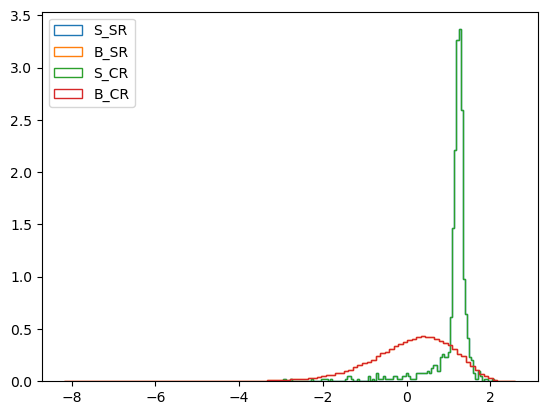

In [11]:
plt.hist(x_train_S[:,2][x_train_S[:,-1]==1], bins=100, label='S_SR', density=True, histtype='step')
plt.hist(x_train_S[:,2][x_train_B[:,-1]==0], bins=100, label='B_SR', density=True, histtype='step')
plt.hist(x_train_B[:,2][x_train_B[:,-1]==1], bins=100, label='S_CR', density=True, histtype='step')
plt.hist(x_train_B[:,2][x_train_B[:,-1]==0], bins=100, label='B_CR', density=True, histtype='step')


plt.legend()
plt.show()

In [12]:


# create masked test data
_x_test = np.load(f'{args.data_dir}/x_test.npy')
_, mask_CR = logit_transform(_x_test[:,1:-1], pre_parameters_CR['min'],
                                pre_parameters_CR['max'])
_, mask_SR = logit_transform(_x_test[:,1:-1], pre_parameters_SR['min'],
                                pre_parameters_SR['max'])
mask_test = mask_CR & mask_SR
x_test = _x_test[mask_test]

x_test_CR = preprocess_params_transform(x_test, pre_parameters_CR)
#x_test_SR = preprocess_params_transform(x_test, pre_parameters_SR)
x_test_SR = preprocess_params_transform(x_test, pre_parameters_CR)



In [13]:

if not args.shuffle_split:    
    data_train_S, data_val_S = train_test_split(x_train_S, test_size=0.2, random_state=args.seed)
    data_train_B, data_val_B = train_test_split(x_train_B, test_size=0.2, random_state=args.seed)

else:
    ss_data = ShuffleSplit(n_splits=20, test_size=0.5, random_state=22)

    print(f'doing a shuffle split with split number {args.split}')

    for i, (train_index, test_index) in enumerate(ss_data.split(x_train)):
        if i == args.split:
            data_train_S, data_val_S = x_train_S[train_index], x_train_S[test_index]
            data_train_B, data_val_B = x_train_B[train_index], x_train_B[test_index]
            break



#x_test = preprocess_params_transform(_x_test, pre_parameters)


traintensor_S = torch.from_numpy(data_train_S.astype('float32')).to(device)
traintensor_B = torch.from_numpy(data_train_B.astype('float32')).to(device)

valtensor_S = torch.from_numpy(data_val_S.astype('float32')).to(device)
valtensor_B = torch.from_numpy(data_val_B.astype('float32')).to(device)
#testtensor = torch.from_numpy(x_test.astype('float32')).to(device)

testtensor_S = torch.from_numpy(x_test_SR.astype('float32')).to(device)
testtensor_B = torch.from_numpy(x_test_CR.astype('float32')).to(device)

print('X_train shape', traintensor_S.shape)
print('X_train shape', traintensor_B.shape)

print('X_val shape', valtensor_S.shape)
print('X_val shape', valtensor_B.shape)

print('X_test shape', testtensor_S.shape)
print('X_test shape', testtensor_B.shape)

pre_parameters_S_tensor = pre_parameters_SR.copy()
pre_parameters_B_tensor = pre_parameters_CR.copy()

for key in pre_parameters_S_tensor.keys():
    pre_parameters_S_tensor[key] = torch.from_numpy(pre_parameters_S_tensor[key].astype('float32')).to(device)

for key in pre_parameters_B_tensor.keys():
    pre_parameters_B_tensor[key] = torch.from_numpy(pre_parameters_B_tensor[key].astype('float32')).to(device)


train_tensor = torch.utils.data.TensorDataset(traintensor_S, traintensor_B)
val_tensor = torch.utils.data.TensorDataset(valtensor_S, valtensor_B)

#test_tensor = torch.utils.data.TensorDataset(testtensor)


# Use the standard pytorch DataLoader
batch_size = args.batch_size
trainloader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

test_batch_size=batch_size*5
valloader = torch.utils.data.DataLoader(val_tensor, batch_size=test_batch_size, shuffle=False)
#testloader = torch.utils.data.DataLoader(test_tensor, batch_size=test_batch_size, shuffle=False)



model_S = DensityEstimator(args.S_config_file, eval_mode=False, device=device)



X_train shape torch.Size([97684, 6])
X_train shape torch.Size([97684, 6])
X_val shape torch.Size([24422, 6])
X_val shape torch.Size([24422, 6])
X_test shape torch.Size([366135, 6])
X_test shape torch.Size([366135, 6])
DensityEstimator has 274800 parameters


In [14]:

if args.mode_background == 'train':
    pass

elif args.mode_background == 'freeze':
 #   val_losses = np.load(f'{args.CR_path}/my_ANODE_model_val_losses.npy')
    val_losses = np.load(f'{args.CR_path}/valloss_list.npy')
    best_epoch = np.argmin(val_losses)
    #model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{best_epoch}.par", device=device)
    model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/model_CR_{best_epoch}.pt", device=device)

elif args.mode_background == 'pretrained':
    val_losses = np.load(f'{args.CR_path}/my_ANODE_model_val_losses.npy')
    best_epoch = np.argmin(val_losses)
    model_B = DensityEstimator(args.config_file, eval_mode=False, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{best_epoch}.par", device=device)




valloss = []
trainloss = []



pre_parameters = {}

pre_parameters['CR'] = pre_parameters_B_tensor
pre_parameters['SR'] = pre_parameters_S_tensor


DensityEstimator has 274800 parameters
Loading model parameters from results/nflows_lhc_co/CR_bn_fixed_1000/try_1_0/model_CR_60.pt


In [15]:
#train_data = inverse_transform(traintensor_S, pre_parameters['SR']).cpu().detach().numpy()
#val_data = inverse_transform(valtensor_S, pre_parameters['SR']).cpu().detach().numpy()

train_data = inverse_transform(traintensor_S, pre_parameters['CR']).cpu().detach().numpy()
val_data = inverse_transform(valtensor_S, pre_parameters['CR']).cpu().detach().numpy()


all_data = np.vstack((train_data, val_data))




In [16]:
# one cycle lr scheduler
epochs = 50
optimizer = torch.optim.AdamW(model_S.model.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(model_S.optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=50)

value of w: 0.006321443778454686


/home/rd804/.conda/envs/manode/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  0 trainloss:  5.4340776386061265 valloss:  5.436011075973511
x_samples shape (122106, 5)
all_data shape (122106, 6)


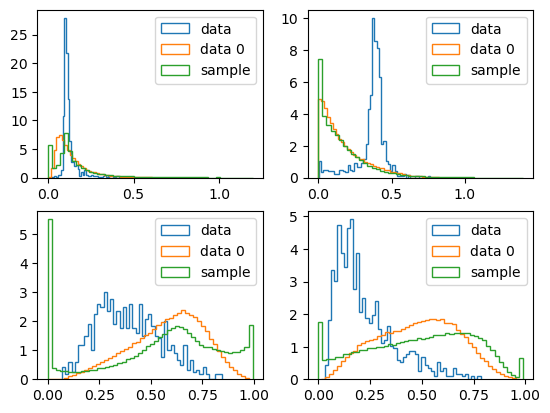

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  1 trainloss:  5.433766598476789 valloss:  5.435335111618042
x_samples shape (122106, 5)
all_data shape (122106, 6)


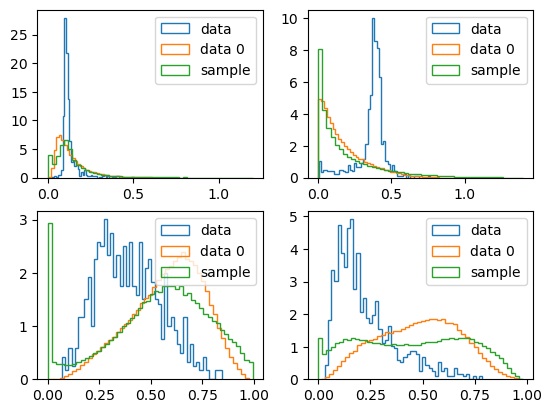

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  2 trainloss:  5.433576758619378 valloss:  5.434266686439514
x_samples shape (122106, 5)
all_data shape (122106, 6)


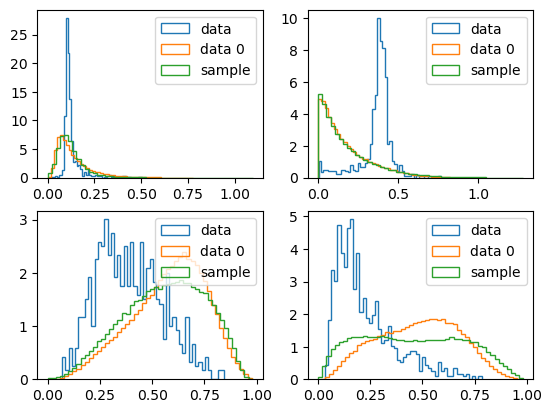

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  3 trainloss:  5.433466159860501 valloss:  5.434390020370484
x_samples shape (122106, 5)
all_data shape (122106, 6)


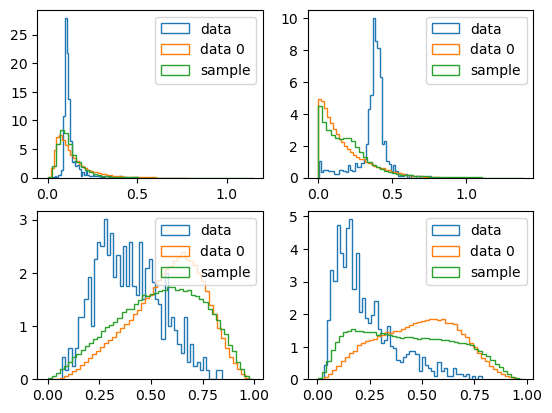

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  4 trainloss:  5.433192414138953 valloss:  5.434286212921142
x_samples shape (122106, 5)
all_data shape (122106, 6)


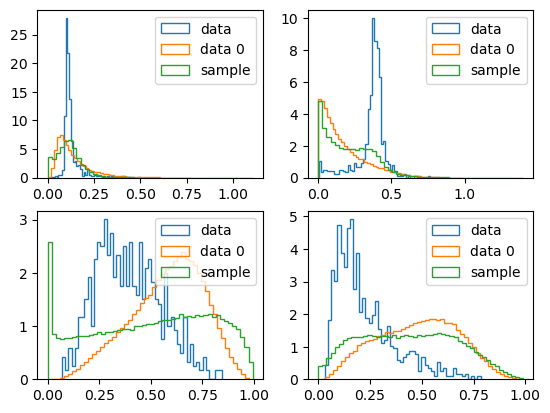

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  5 trainloss:  5.433136121140724 valloss:  5.43358805179596
x_samples shape (122106, 5)
all_data shape (122106, 6)


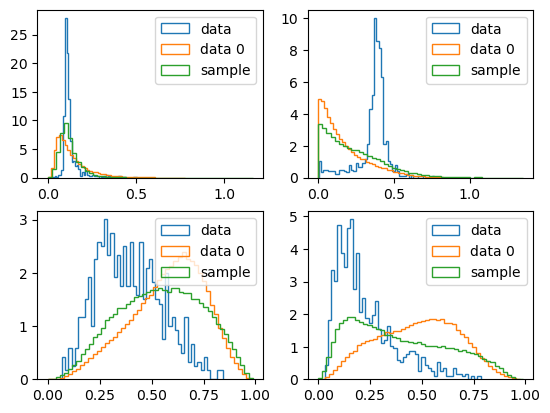

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  6 trainloss:  5.432464746904623 valloss:  5.43265221118927
x_samples shape (122106, 5)
all_data shape (122106, 6)


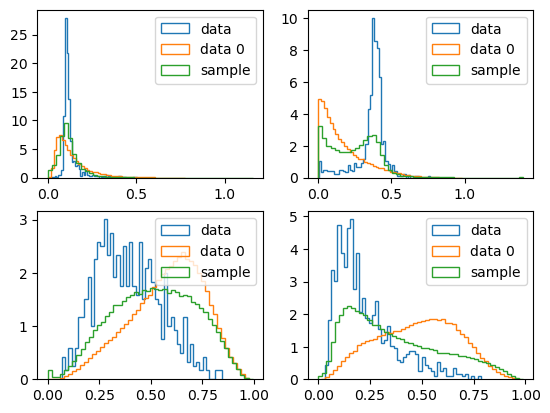

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  7 trainloss:  5.432469778660081 valloss:  5.432795357704163
x_samples shape (122106, 5)
all_data shape (122106, 6)


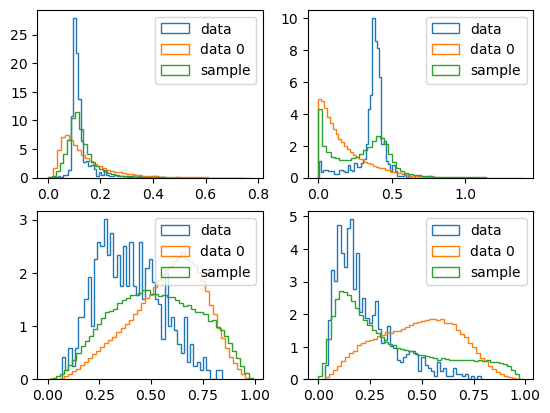

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  8 trainloss:  5.432026572252443 valloss:  5.432009506225586
x_samples shape (122106, 5)
all_data shape (122106, 6)


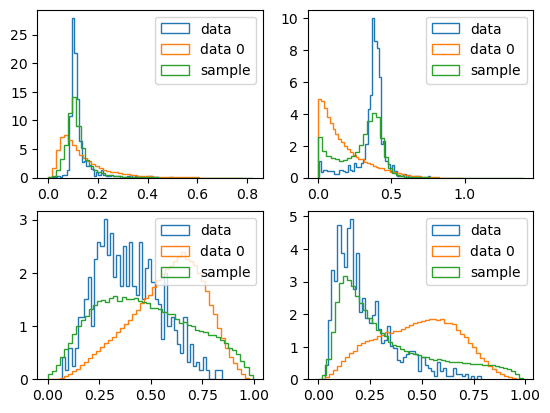

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  9 trainloss:  5.43181081716927 valloss:  5.432299280166626
x_samples shape (122106, 5)
all_data shape (122106, 6)


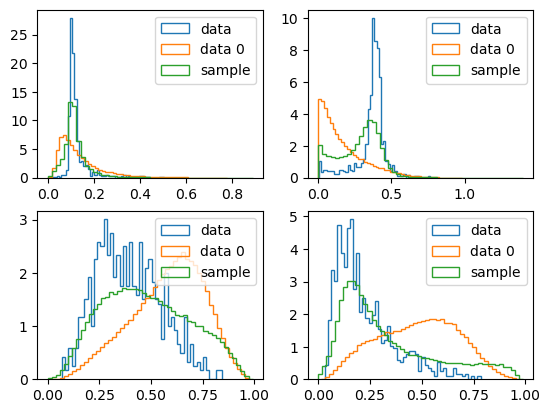

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  10 trainloss:  5.431691793871176 valloss:  5.432426404953003
x_samples shape (122106, 5)
all_data shape (122106, 6)


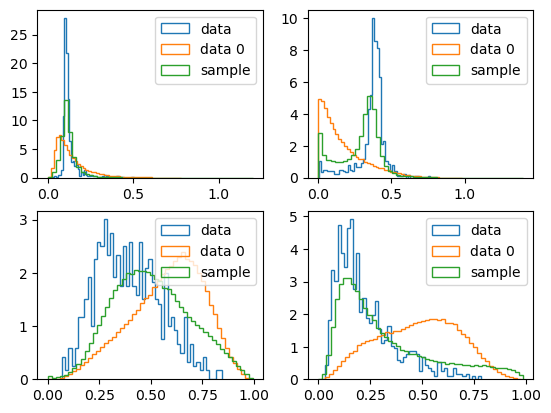

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  11 trainloss:  5.4318100482381455 valloss:  5.432301330566406
x_samples shape (122106, 5)
all_data shape (122106, 6)


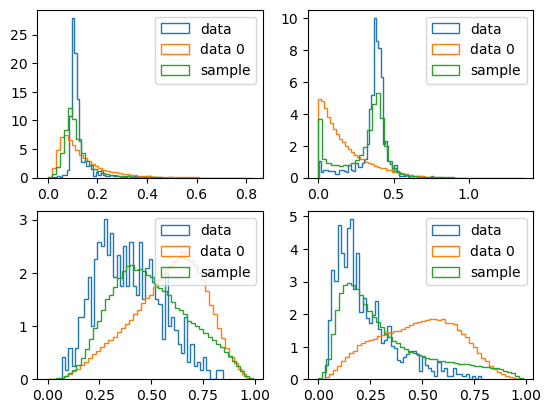

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  12 trainloss:  5.431622743606567 valloss:  5.432262253761292
x_samples shape (122106, 5)
all_data shape (122106, 6)


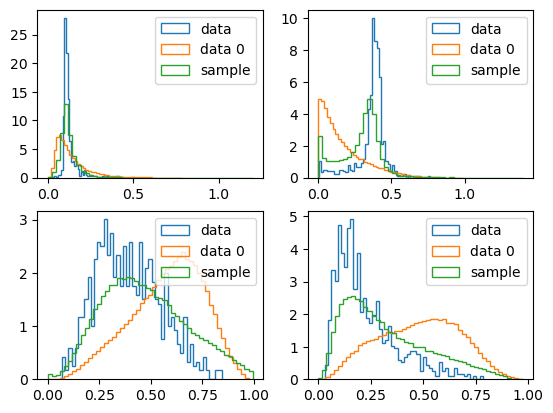

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  13 trainloss:  5.431824018817921 valloss:  5.432028150558471
x_samples shape (122106, 5)
all_data shape (122106, 6)


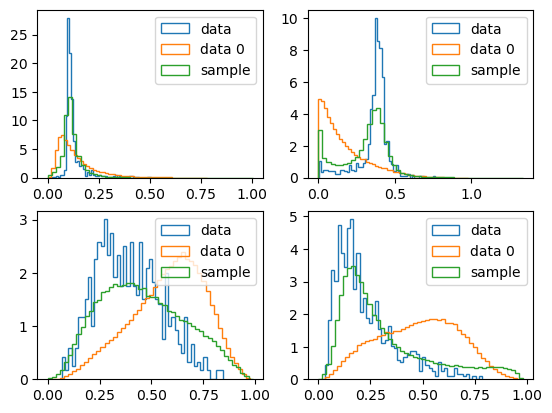

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  14 trainloss:  5.431383350132648 valloss:  5.432514119148254
x_samples shape (122106, 5)
all_data shape (122106, 6)


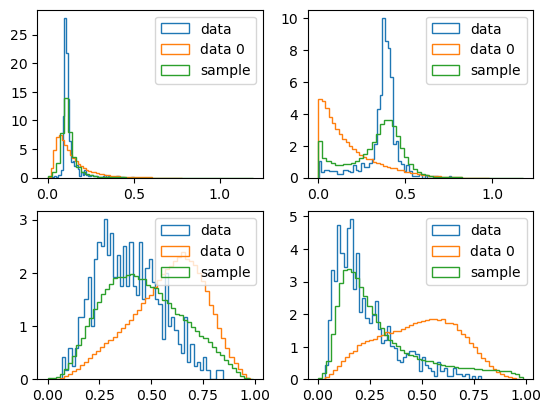

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  15 trainloss:  5.4315808880391545 valloss:  5.432440257072448
x_samples shape (122106, 5)
all_data shape (122106, 6)


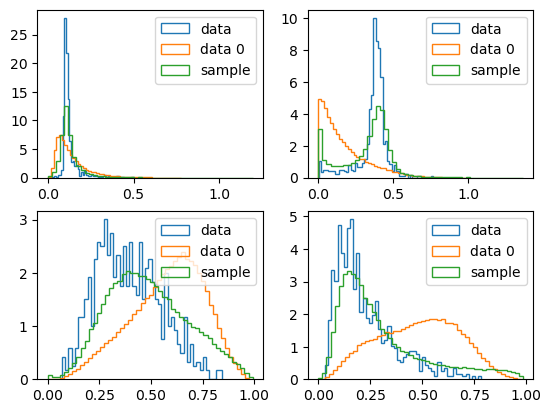

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  16 trainloss:  5.43125133239786 valloss:  5.434555530548096
x_samples shape (122106, 5)
all_data shape (122106, 6)


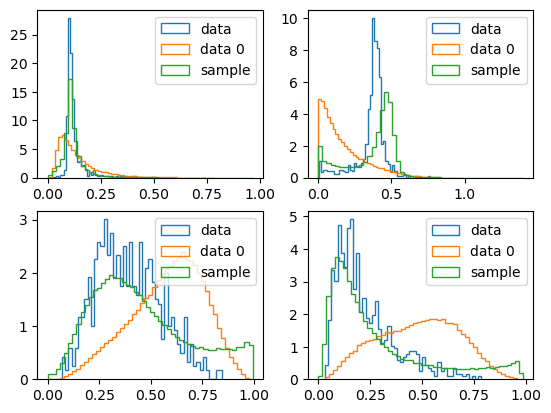

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  17 trainloss:  5.431235367090914 valloss:  5.432029294967651
x_samples shape (122106, 5)
all_data shape (122106, 6)


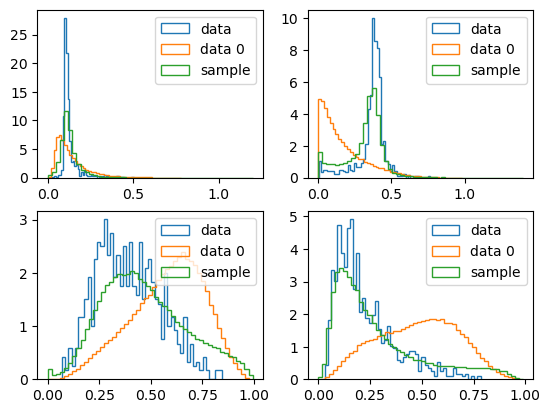

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  18 trainloss:  5.4312127822356695 valloss:  5.432105040550232
x_samples shape (122106, 5)
all_data shape (122106, 6)


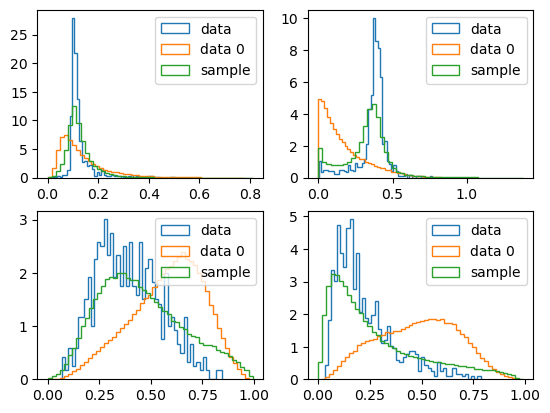

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  19 trainloss:  5.431189845369748 valloss:  5.432683324813842
x_samples shape (122106, 5)
all_data shape (122106, 6)


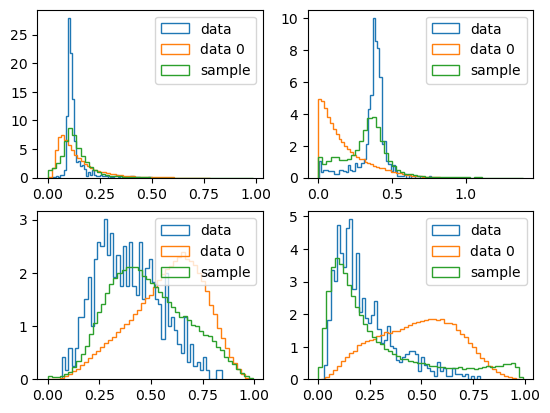

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  20 trainloss:  5.430979726202201 valloss:  5.432238459587097
x_samples shape (122106, 5)
all_data shape (122106, 6)


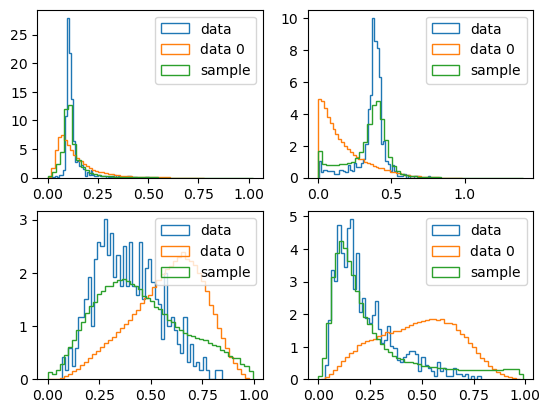

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  21 trainloss:  5.4310567903269025 valloss:  5.431910753250122
x_samples shape (122106, 5)
all_data shape (122106, 6)


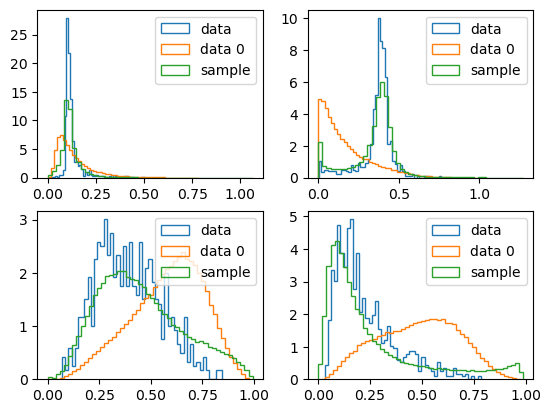

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  22 trainloss:  5.430855221773317 valloss:  5.432375812530518
x_samples shape (122106, 5)
all_data shape (122106, 6)


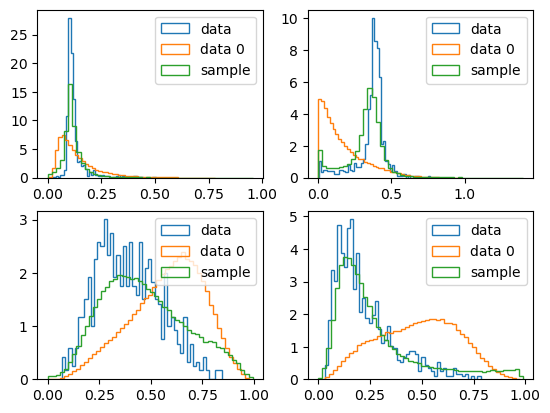

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  23 trainloss:  5.431385691877435 valloss:  5.431761837005615
x_samples shape (122106, 5)
all_data shape (122106, 6)


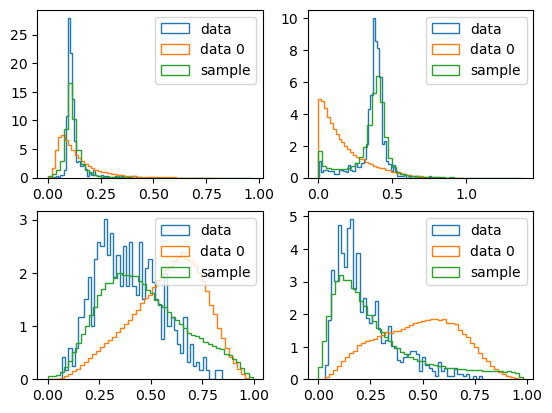

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  24 trainloss:  5.430691167322129 valloss:  5.431487894058227
x_samples shape (122106, 5)
all_data shape (122106, 6)


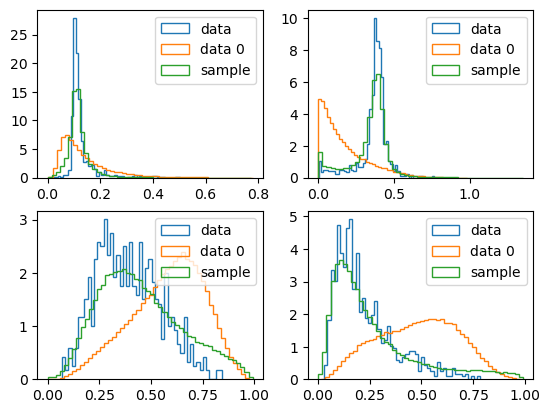

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  25 trainloss:  5.430499960614749 valloss:  5.431910443305969
x_samples shape (122106, 5)
all_data shape (122106, 6)


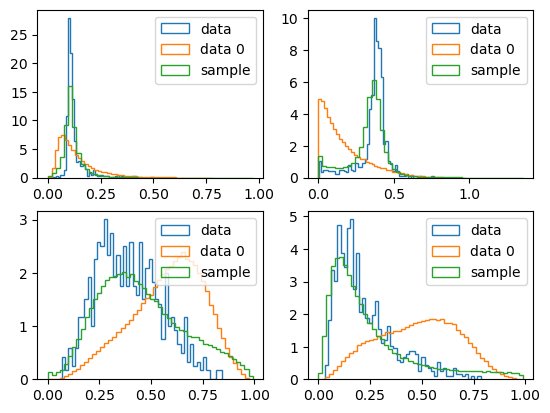

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  26 trainloss:  5.430758315231164 valloss:  5.431771326065063
x_samples shape (122106, 5)
all_data shape (122106, 6)


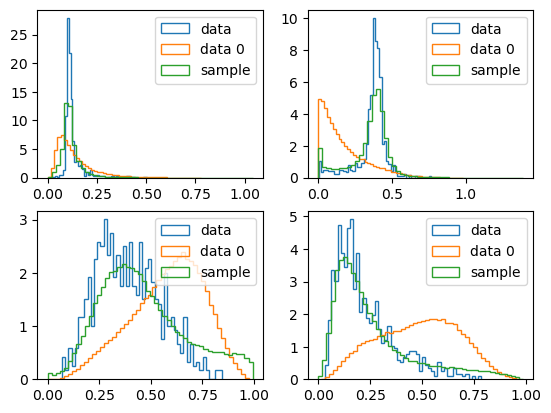

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  27 trainloss:  5.430544332684023 valloss:  5.432130599021912
x_samples shape (122106, 5)
all_data shape (122106, 6)


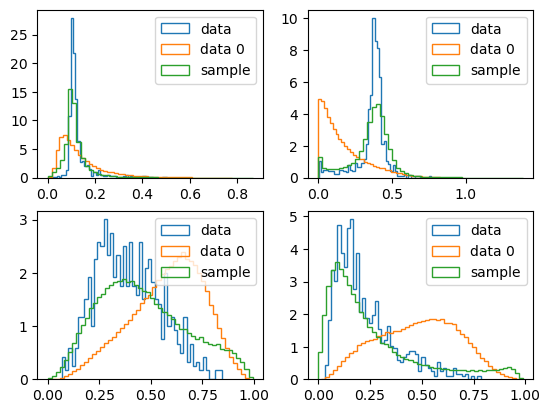

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  28 trainloss:  5.430796016573281 valloss:  5.431925177574158
x_samples shape (122106, 5)
all_data shape (122106, 6)


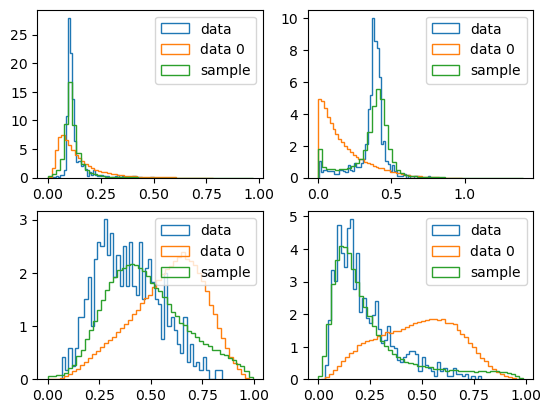

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  29 trainloss:  5.431049416826657 valloss:  5.433265471458435
x_samples shape (122106, 5)
all_data shape (122106, 6)


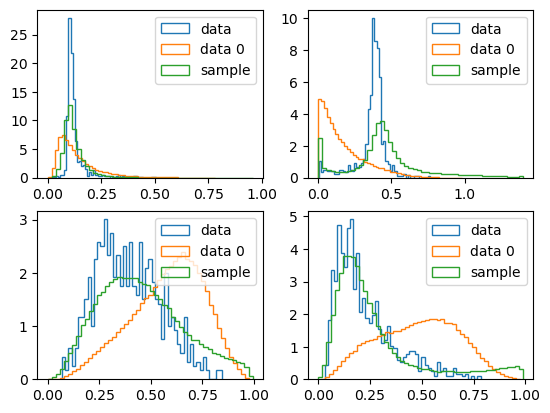

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  30 trainloss:  5.430490385175376 valloss:  5.432069873809814
x_samples shape (122106, 5)
all_data shape (122106, 6)


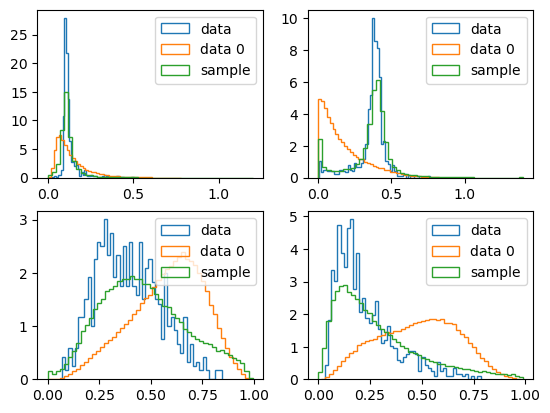

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  31 trainloss:  5.430628696661345 valloss:  5.431813192367554
x_samples shape (122106, 5)
all_data shape (122106, 6)


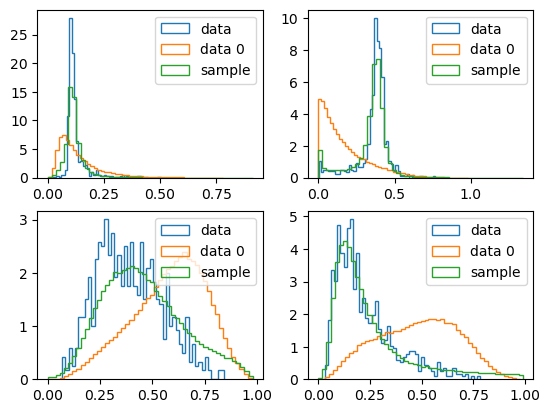

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  32 trainloss:  5.430878700386168 valloss:  5.432108545303345
x_samples shape (122106, 5)
all_data shape (122106, 6)


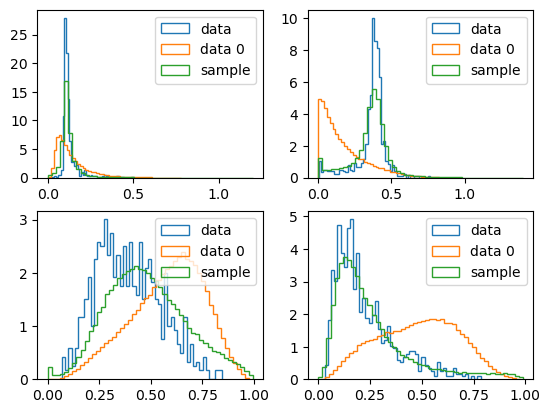

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  33 trainloss:  5.430650295387388 valloss:  5.431691765785217
x_samples shape (122106, 5)
all_data shape (122106, 6)


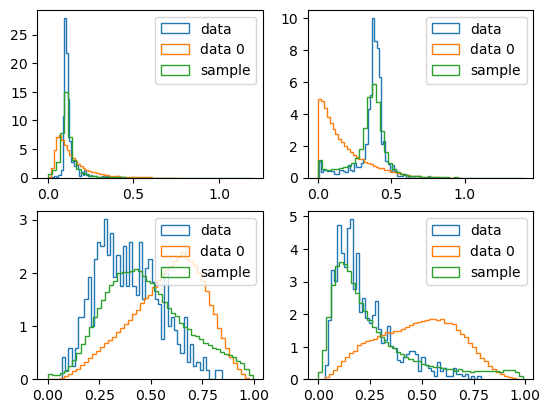

value of w: 0.006321443778454686
setting batch norm layers to eval mode
value of w: 0.006321443778454686
epoch:  34 trainloss:  5.430464727092164 valloss:  5.431592249870301
x_samples shape (122106, 5)
all_data shape (122106, 6)


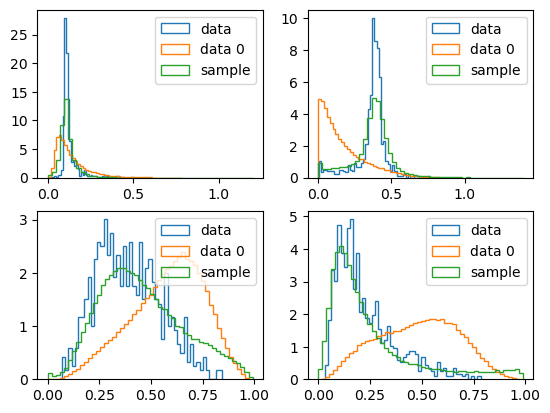

value of w: 0.006321443778454686


KeyboardInterrupt: 

In [17]:

for epoch in range(50):

    train_loss = r_anode(model_S.model,model_B.model,true_w,optimizer, scheduler, trainloader, 
                         pre_parameters, device=device, mode='train',\
                          data_loss_expr=args.data_loss_expr)
    val_loss = r_anode(model_S.model,model_B.model,true_w,optimizer, scheduler, valloader, 
                       pre_parameters, device=device, mode='val',\
                        data_loss_expr=args.data_loss_expr)


    ##################################
    ##############################
    # Save model and weights

    torch.save(model_S.model.state_dict(), f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{epoch}.pt')

    
    if args.mode_background == 'train' or args.mode_background == 'pretrained':
        torch.save(model_B.model.state_dict(), f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_B_{epoch}.pt')


    if args.wandb:
            wandb.log({'train_loss': train_loss, 'val_loss': val_loss, \
                'true_w': true_w})


    if np.isnan(train_loss) or np.isnan(val_loss):
        print(' nan loss ')
       # if args.wandb:
        #    wandb.finish()
        #break

    

    print('epoch: ', epoch, 'trainloss: ', train_loss, 'valloss: ', val_loss)
    valloss.append(val_loss)
    trainloss.append(train_loss)

   # x_samples_train = generate_transformed_samples(model_S.model, traintensor_S, pre_parameters['SR'], device=device).cpu().detach().numpy()
   # x_samples_val = generate_transformed_samples(model_S.model, valtensor_S, pre_parameters['SR'], device=device).cpu().detach().numpy()
    x_samples_train = generate_transformed_samples(model_S.model, traintensor_S, pre_parameters['CR'], device=device).cpu().detach().numpy()
    x_samples_val = generate_transformed_samples(model_S.model, valtensor_S, pre_parameters['CR'], device=device).cpu().detach().numpy()
    

    x_samples = np.vstack((x_samples_train, x_samples_val))

    print('x_samples shape', x_samples.shape)
    print('all_data shape', all_data.shape)

    for i in range(1,5):
        plt.subplot(2,2,i)
        #if dims > 1:
        plt.hist(all_data[:,i][all_data[:,-1]==1],bins=50, density=True, label=f'data', histtype='step')
        plt.hist(all_data[:,i][all_data[:,-1]==0],bins=50, density=True, label=f'data 0', histtype='step')
        plt.hist(x_samples[:,i],bins=50, density=True, label=f'sample', histtype='step')
        plt.legend(loc='upper right')
    # plt.title(f'Nflow vs S for {i}, epoch {epoch}')
        plt.savefig(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/nflow_S_{i}.png')
        if args.wandb:
            wandb.log({f'nflow_S': wandb.Image(figure)})

    plt.show()



In [21]:
x_samples_train = generate_transformed_samples(model_S.model, traintensor_S, pre_parameters['SR'], device=device).cpu().detach().numpy()
x_samples_val = generate_transformed_samples(model_S.model, valtensor_S, pre_parameters['SR'], device=device).cpu().detach().numpy()


x_samples = np.vstack((x_samples_train, x_samples_val))



AttributeError: 'BatchNormFlow' object has no attribute 'batch_mean'

DensityEstimator has 274800 parameters


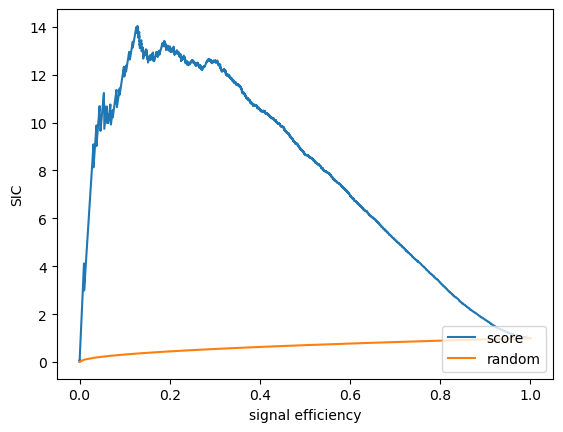

In [18]:


#if ~np.isnan(train_loss) or ~np.isnan(val_loss):


# Load best model
if not args.ensemble:
    index = np.argmin(valloss).flatten()[0]

    model_S.model.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{index}.pt'))
    
    model_S.model.eval()
    log_S = evaluate_log_prob(model_S.model, testtensor_S, 
                                pre_parameters['SR'], transform = True).cpu().detach().numpy()
    #S = np.exp(log_S)


else:
    log_S = []
    sorted_index = np.argsort(valloss).flatten()[0:10]
    for index in sorted_index:

        model_S.model.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_S_{index}.pt'))
        
        model_S.model.eval()
        log_S_ = evaluate_log_prob(model_S.model, testtensor_S, 
                                    pre_parameters['SR'], transform = True).cpu().detach().numpy()
        log_S.append(log_S_)

    log_S = np.array(log_S)
    S = np.exp(log_S)
    S = np.mean(S, axis=0)
    log_S = np.log(S + 1e-32)


if args.mode_background == 'train' or args.mode_background == 'pretrained':
    model_B.model.load_state_dict(torch.load(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/model_B_{index}.pt'))

test_data = inverse_transform(testtensor_S, pre_parameters['SR']).cpu().detach().numpy()
label_test = test_data[:,-1]

model_S.model.eval()

train_data = inverse_transform(traintensor_S, pre_parameters['SR']).cpu().detach().numpy()
val_data = inverse_transform(valtensor_S, pre_parameters['SR']).cpu().detach().numpy()





# load CR model
val_losses = np.load(f'{args.CR_path}/valloss_list.npy')

if not args.ensemble:
    best_epoch = np.argsort(val_losses)[0]
else:
    best_epoch = np.argsort(val_losses)[0:10]


model_B = DensityEstimator(args.config_file, eval_mode=True, device=device)
log_B = []
for epoch in best_epoch:
#  model_B = DensityEstimator(args.config_file, eval_mode=True, load_path=f"{args.CR_path}/my_ANODE_model_epoch_{epoch}.par", device=device)
    model_B.model.load_state_dict(torch.load(f'{args.CR_path}/model_CR_{epoch}.pt'))

    model_B.model.eval()
    with torch.no_grad():
        log_p = evaluate_log_prob(model_B.model, testtensor_B, pre_parameters['CR'], transform=True).cpu().detach().numpy()
        log_B.append(log_p)

log_B = np.array(log_B)
log_B = np.mean(log_B, axis=0)

likelihood_ = log_S - log_B
likelihood = np.nan_to_num(likelihood_, nan=0, posinf=0, neginf=0)        


sic_score , tpr_score , auc_score = SIC(label_test, likelihood)

figure = plt.figure()

plt.plot(tpr_score, sic_score, label='score')
plt.plot(tpr_score, tpr_score**0.5, label='random')
plt.xlabel('signal efficiency')
plt.ylabel('SIC')

plt.legend(loc='lower right')
if args.wandb:
    wandb.log({'SIC': wandb.Image(figure)})
    wandb.log({'AUC': auc_score, 'max SIC': np.max(sic_score)})

plt.savefig(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/SIC.png')
plt.show()


# check density estimation


np.save(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/valloss.npy', valloss)
np.save(f'results/{args.wandb_group}/{args.wandb_job_type}/{args.wandb_run_name}/trainloss.npy', trainloss)

if args.wandb:
    wandb.finish()






